In [1]:
%precision %.4f
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from IPython.core.display import HTML

In [2]:
import graphviz
from graphviz import Source
from sklearn.tree import export_graphviz

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [4]:
# use PCA to find principal components
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [5]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [6]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [7]:
# Projecting training set onto the plance defined PCA's c1 and c2
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

X2D_using_svd = X2D

In [8]:
#Using scikit-learn
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
#X2D

In [9]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance, sum(explained_variance))

[0.84248607 0.14631839] 0.988804464429311


In [10]:
#print(X2D_using_svd.shape, X2D.shape)
#print(X2D_using_svd[:5])
#print(X2D[:5])
np.allclose(X2D_using_svd[:5], X2D[:5]) or np.allclose(-X2D_using_svd[:5], X2D[:5])

True

In [11]:
#Recover the 3D points projected on the plane (PCA 2D subspace).
X3D_inv  = pca.inverse_transform(X2D)
np.allclose(X3D_inv, X)

False

In [12]:
# Reconstruction error:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [13]:
#The inverse transform in the SVD approach.
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)


True

In [14]:
# The PCA object gives access to the principal components that it computed

pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [15]:
Vt[:2]
# axes are flipped, but it's more or less the same

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [16]:
print (pca.explained_variance_ratio_ )
print (1 - pca.explained_variance_ratio_.sum() )

[0.84248607 0.14631839]
0.011195535570688975


In [17]:
# Calculating the same using svd approach. S is diagonal matrix wth pricipal components 
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [18]:
# number of dimensions can be set using explained variance ration above some threshold
pca2 = PCA()
pca2.fit(X)

cumsum = np.cumsum(pca2.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

2

In [19]:
# or just set number of pricipal componets to float bwtween 0.0 and 1.0
# indicating ratio of variance to be preserved
pca3 = PCA(n_components=0.95)
X_reduced = pca3.fit_transform(X)

In [20]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [21]:
#Express the plane as a function of x and y.

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Saving figure dataset_3d_plot


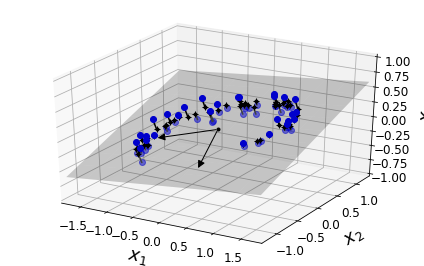

In [22]:
#Plot the 3D dataset, the plane and the projections on that plane.

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()


Saving figure dataset_2d_plot


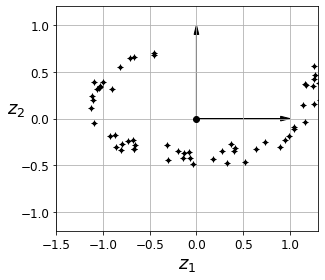

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

Manifold learning

In [24]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


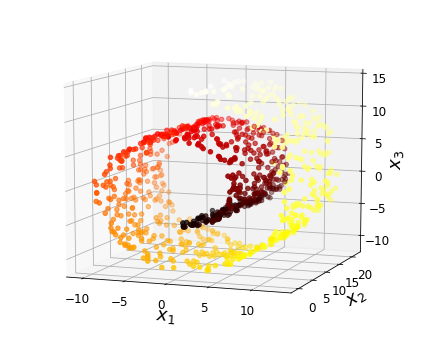

In [25]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()


Saving figure squished_swiss_roll_plot


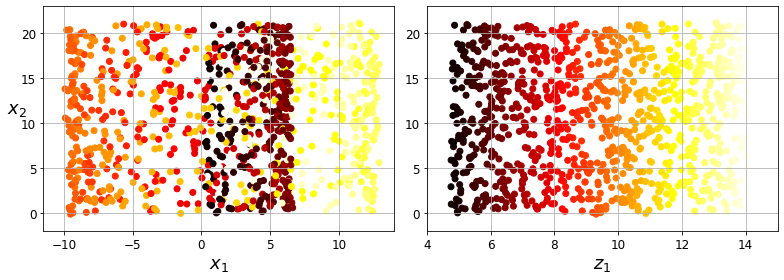

In [26]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

Saving figure manifold_decision_boundary_plot1


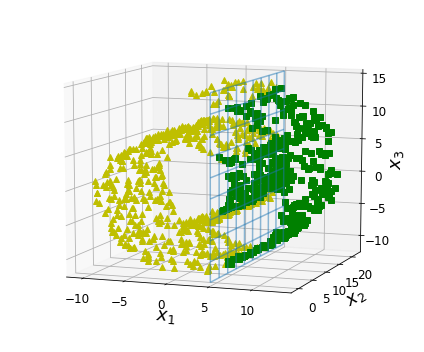

Saving figure manifold_decision_boundary_plot2


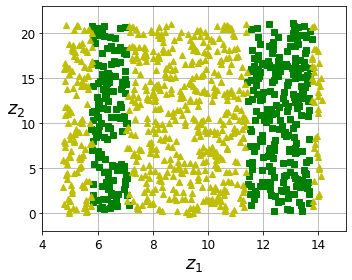

Saving figure manifold_decision_boundary_plot3


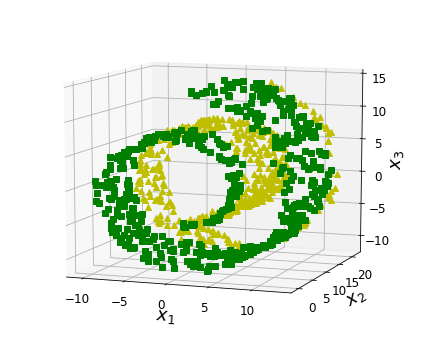

Saving figure manifold_decision_boundary_plot4


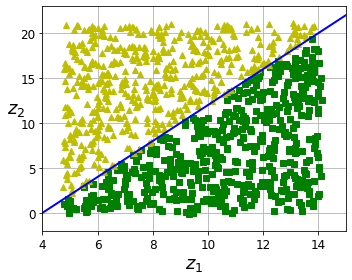

In [27]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

PCA

Saving figure pca_best_projection_plot


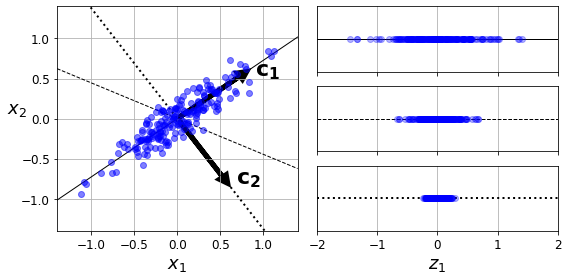

In [28]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

MNIST compression

In [29]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [30]:
pca_mnist = PCA()
pca_mnist.fit(X)

cumsum = np.cumsum(pca_mnist.explained_variance_ratio_)

d = np.argmax(cumsum >= 0.95) + 1
d



154

In [31]:
ratio_arr = [(ratio, np.argmax(cumsum >= ratio) + 1) for ratio in [0.75, 0.85, 0.9, 0.95, 0.97, 0.99] ]
ratio_arr

[(0.7500, 33),
 (0.8500, 59),
 (0.9000, 87),
 (0.9500, 154),
 (0.9700, 214),
 (0.9900, 331)]

Saving figure explained_variance_plot


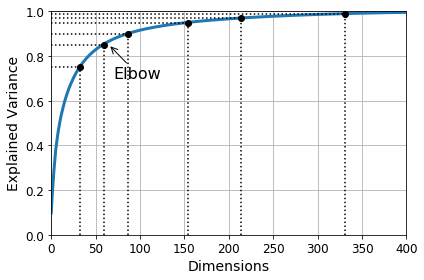

In [32]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
for (ratio, dim) in ratio_arr: 
    plt.plot([dim, dim], [0, ratio], "k:")
    plt.plot([0, dim], [ratio, ratio], "k:")
    plt.plot(dim, ratio, "ko")

#plt.plot([d, d], [0, 0.95], "k:")
#plt.plot([0, d], [0.95, 0.95], "k:")
#plt.plot(d, 0.95, "ko")

plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [33]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [34]:
pca.n_components_

154

In [35]:
sum(pca.explained_variance_ratio_)

0.9504334914295709

In [36]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [37]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


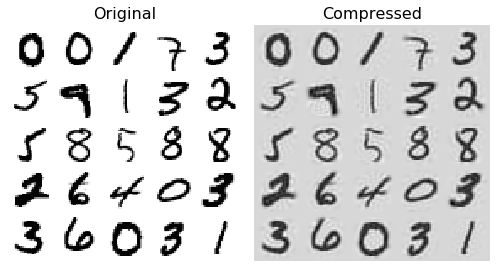

In [38]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")


In [39]:
ratios = [0.5, 0.75, 0.85, 0.9, 0.95, 0.97, 0.99, 0.995]
pcas = []
X_reduced_arr = []
X_recovered_arr = []

for ratio in ratios:
    pca = PCA(n_components = ratio)
    X_reduced = pca.fit_transform(X_train)
    X_recovered = pca.inverse_transform(X_reduced)
    pcas.append(pca)
    X_reduced_arr.append(X_reduced)
    X_recovered_arr.append(X_recovered)


Saving figure mnist_compression_plot_multi


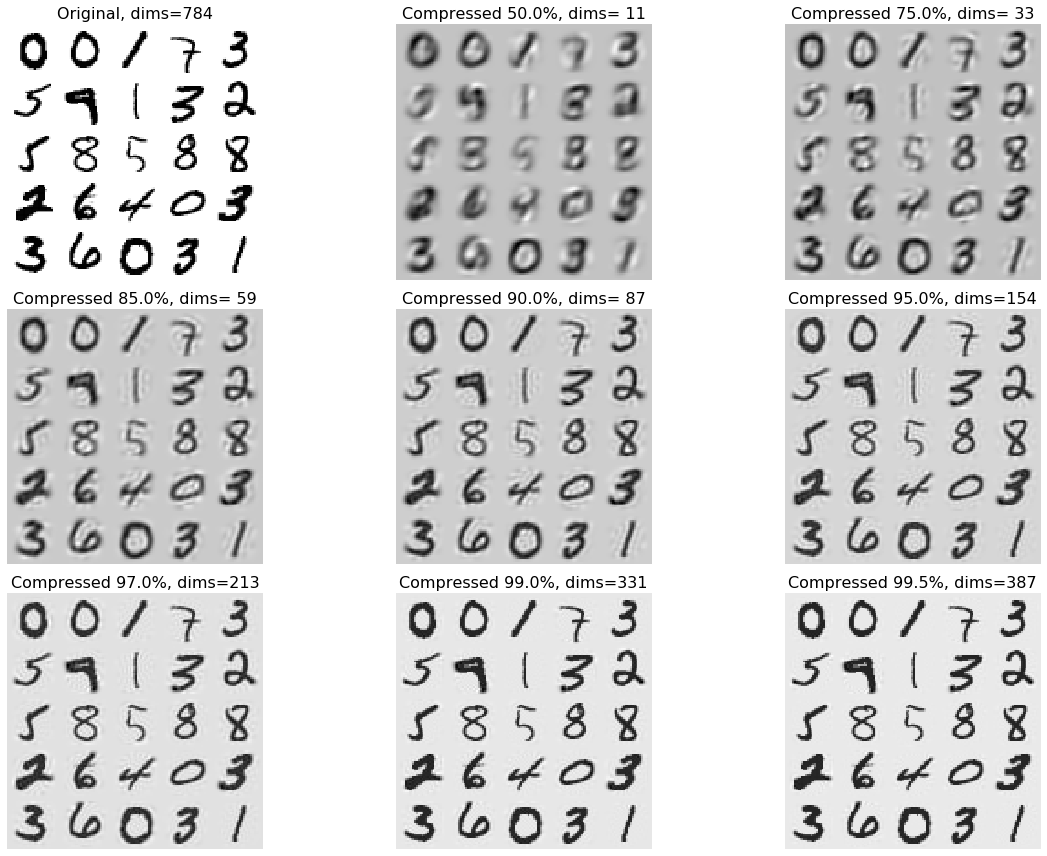

In [40]:
plot_index = 1
n_rows = 3
n_columns = (len(ratios) + 1) // n_rows
plt.figure(figsize=(20, 12))

plt.subplot(n_rows, n_columns, plot_index)
plot_digits(X_train[::2100])
plt.title("Original, dims={0:3d}".format(X_train.shape[1]), fontsize=16)

for index, ratio in enumerate(ratios):
    plot_index+=1
    #print ( subplot_num )
    plt.subplot(n_rows, n_columns, plot_index)
    plot_digits(X_recovered_arr[index][::2100])
    plt.title("Compressed {0:.1f}%, dims={1:3d}".format(100*ratio, pcas[index].n_components_), fontsize=16)
    
plt.tight_layout()
save_fig("mnist_compression_plot_multi") 

In [41]:
pca.n_components_

387

Incremental PCA

In [42]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [43]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

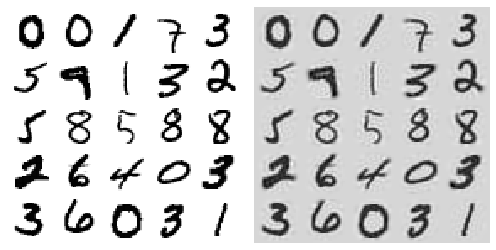

In [44]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [45]:
# use NumPy memmap class to manipulate large array stored in binary file on disk

filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train


In [46]:
# deleting bject will trigger finalizer which will save data on disk
del X_mm

In [47]:
# to read the object back into memory
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
batch_size = m // n_batches
inc_pca2 = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca2.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [48]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

Time complexity

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [49]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 1.1 seconds
    IncrementalPCA: 7.8 seconds
    PCA: 1.0 seconds
n_components = 10
    PCA: 1.2 seconds
    IncrementalPCA: 8.0 seconds
    PCA: 1.2 seconds
n_components = 154
    PCA: 3.0 seconds
    IncrementalPCA: 10.3 seconds
    PCA: 3.0 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

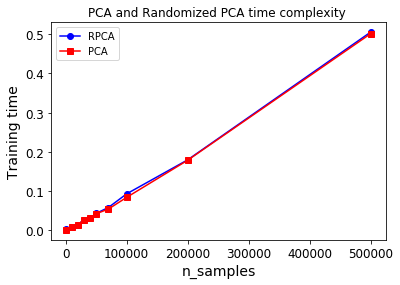

In [50]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

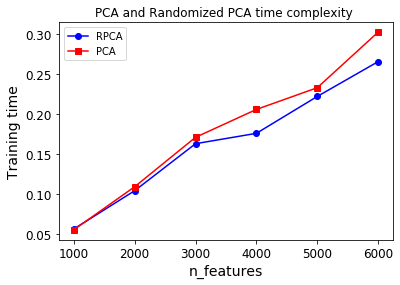

In [51]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

**Kernel PCA**

In [52]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [53]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced=rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


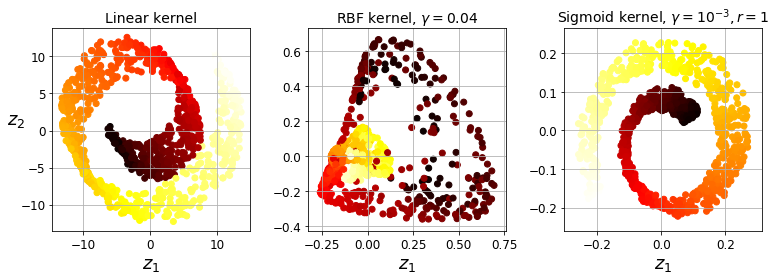

In [54]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

In [55]:
# Tune hyperparameters using GridSearch

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
]
)

param_grid = [{
    "kpca__gamma": np.linspace(0.01, 0.05, 100),
    "kpca__kernel": ["rbf", "sigmoid"]    
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)



GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [56]:
#grid_search.best_params_

best_params = dict([(key.replace("kpca__", ""), value) for (key, value) in grid_search.best_params_.items()])
print(best_params)
gbest_kpca = KernelPCA(n_components=2, fit_inverse_transform=True, **best_params)
#"kpca__gamma".replace("kpca__", "")

{'gamma': 0.04474747474747475, 'kernel': 'rbf'}


Saving figure kernel_best_pca_plot


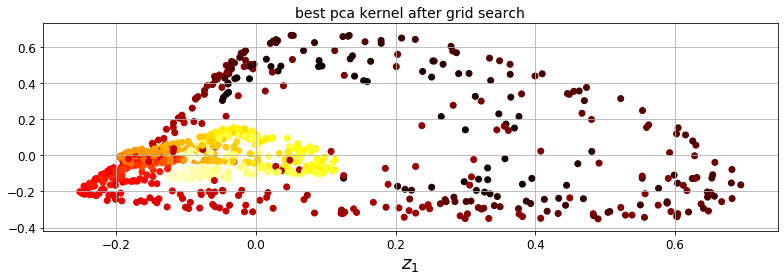

In [57]:
plt.figure(figsize=(11, 4))

X_reduced = gbest_kpca.fit_transform(X)

plt.subplot(111)
#plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
#plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
plt.title("best pca kernel after grid search", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)

plt.grid(True)

save_fig("kernel_best_pca_plot")
plt.show()

In [58]:
# Another approach -> select kernel and hyperparameters that have lowest reconstruction error

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)


In [59]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576615

LLE - Locally Linear Embedding

In [60]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [61]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


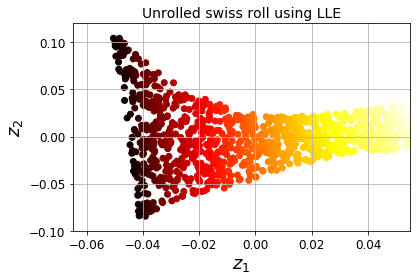

In [62]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()


**MDS, Isomap and t-SNE**

In [63]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [64]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [66]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

Saving figure other_dim_reduction_plot


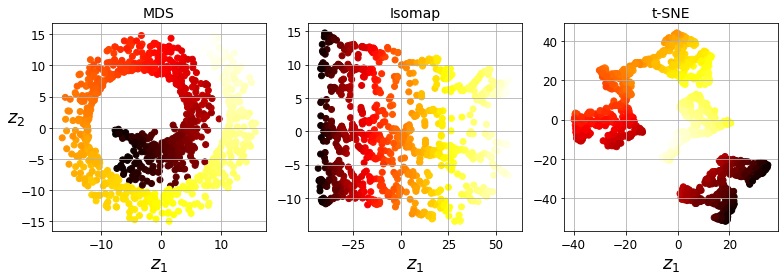

In [67]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)


mnist_rnd_clf = RandomForestClassifier(n_estimators=200, n_jobs=-2)

t1 = time.time()

t2 = time.time()
#print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

# %timeit
%time mnist_rnd_clf.fit(X_train, y_train)
mnist_y_pred = mnist_rnd_clf.predict(X_test)

print(mnist_rnd_clf.__class__.__name__, accuracy_score(y_test, mnist_y_pred))

Wall time: 15.5 s
RandomForestClassifier 0.9693142857142857


In [69]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

mnist_rnd_clf2 = RandomForestClassifier(n_estimators=200, n_jobs=-2)
%time mnist_rnd_clf2.fit(X_train_reduced, y_train)

X_test_reduced = pca.transform(X_test)

mnist_y_pred = mnist_rnd_clf2.predict(X_test_reduced)

print(mnist_rnd_clf2.__class__.__name__, accuracy_score(y_test, mnist_y_pred))

Wall time: 28.5 s
RandomForestClassifier 0.9486285714285714


In [71]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

m = 10**4
rand_idx = np.random.permutation(60000)[:m]

X = mnist['data'][rand_idx]
y = mnist['target'][rand_idx]


In [74]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
%time X_reduced = tsne.fit_transform(X)

Wall time: 2min 45s


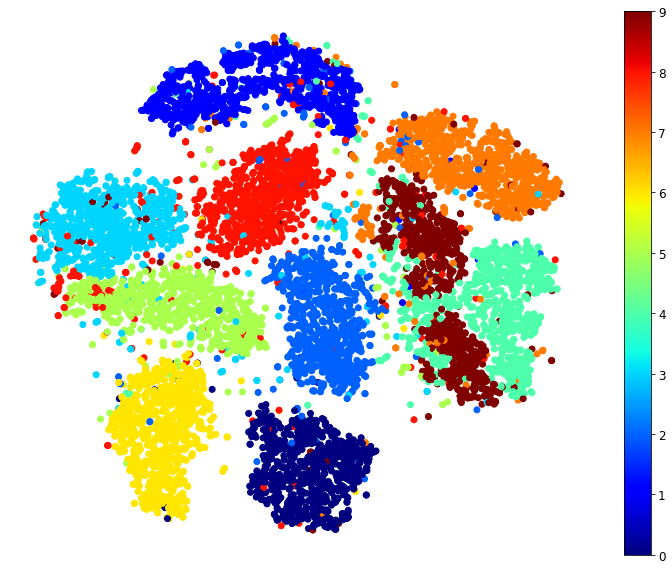

In [75]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")

plt.axis('off')
plt.colorbar()
plt.show()

In [76]:
from sklearn.manifold import TSNE

tsne_3 = TSNE(n_components=3)
%time X_reduced_3 = tsne_3.fit_transform(X)


Wall time: 4min


c:\Users\michal\Anaconda3\envs\ML\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


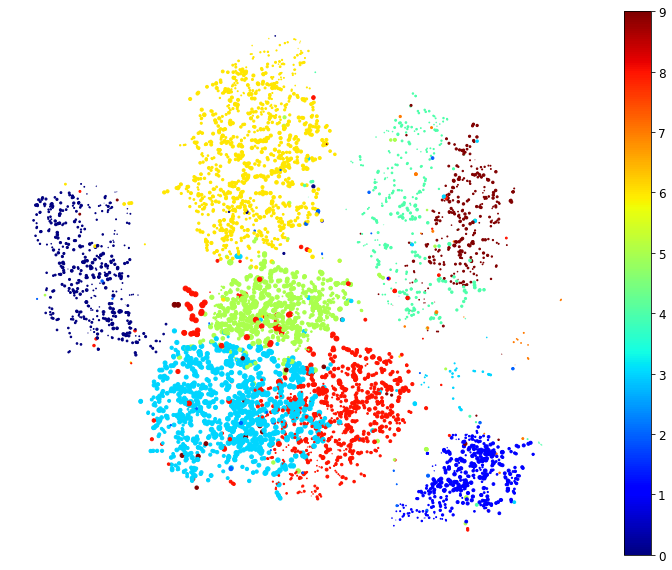

In [77]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced_3[:, 0], X_reduced_3[:, 1], X_reduced_3[:, 2], c=y, cmap="jet")

plt.axis('off')
plt.colorbar()
plt.show()